This notebook reads files outputted from the preprocessing phase (indeed_cleaning.ipynb) to output relevant visualizations for the reports.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
import json
import time

from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import pytz

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import dtale

%matplotlib inline

In [2]:
indeed_master = pd.read_csv('indeed_master.csv')

In [3]:
indeed_main = pd.read_csv('indeedjobs.csv')

In [4]:
skills = pd.read_csv('indeed_skills.csv')

# Data Jobs EDA

In [5]:
data_df = pd.merge(skills, indeed_main, on='id')

In [6]:
data_df.sample(5)

id                 skill    category  \
14531  c3eefc07f4cfb318bc665f494975b807                     1    Quantity   
9125   f23ff52bb327d909fdfbdd1f4adbe31a                degree    Quantity   
1559   53e34eb3100f10b1a5661657dc68ef0f  technical consulting       Skill   
6554   8b49bbac1462d290c182309117e1c499                office    Location   
8279   879e3dee5cf1e302dd61de49cdf13c46              customer  PersonType   

       confidence score posting_date  \
14531              0.80   2020-12-22   
9125               0.80   2019-10-22   
1559               0.84   2019-10-18   
6554               0.55   2019-09-19   
8279               0.96   2019-10-13   

                                             description  \
14531  commercial banking serves global clients, incl...   
9125    overview exciting opportunity team defining u...   
1559   join sada data engineering manager! mission da...   
6554    role: research/data analyst position help gui...   
8279   data analyst, planning & inventory data analys...   

                                                   title  \
14531                Software Engineering- Data Engineer   
9125   Senior Business Data Analyst-Web/Digital Analy...   
1559                            Data Engineering Manager   
6554                               Research/Data Analyst   
8279                  Data Analyst, Planning & Inventory   

                               employer industry  source        country  
14531         JPMorgan Chase Bank, N.A.       IT  Indeed          India  
9125                             Intuit      NaN  Indeed  United States  
1559                               SADA      NaN  Indeed  United States  
6554                                JLL      NaN  Indeed  United States  
8279   Carpenter Technology Corporation      NaN  Indeed  United States

In [7]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [8]:
# plot skills mentioned by data related jobs
alt.Chart(skills.loc[(skills['category'] == 'Skill') | (skills['category'] == 'Product')]).mark_bar().encode(
    y=alt.Y('skill:N', sort=alt.SortField(field='count', order='descending'), title="Skill"),
    x=alt.X('count:Q', title="Number of Job Posts")
).properties(
    title='Top 20 Skills Mentioned by Data Related Jobs'
).transform_aggregate(
    count='count()',
    groupby=['skill']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 20')

alt.Chart(...)

In [9]:
alt.Chart(skills.loc[(skills['category'] == 'Product')]).mark_bar().encode(
    y=alt.Y('skill:N', sort=alt.SortField(field='count', order='descending'), title="Product"),
    x=alt.X('count:Q', title="Number of Job Posts")
).properties(
    title='Top Products Mentioned by Data Related Jobs'
).transform_aggregate(
    count='count()',
    groupby=['skill']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 20')

alt.Chart(...)

# Data Scientist Jobs EDA

In [10]:
indeed_ds = pd.read_csv('indeedDSjobs.csv')
indeed_ds.reset_index(drop=True, inplace=True)

In [11]:
ds_skills = pd.read_csv('indeed_ds_skills.csv')

In [12]:
# merge job information and extracted skills
ds_df = pd.merge(ds_skills, indeed_ds)
ds_df.sample(5)

id         skill    category  \
2956  14ee71e696dc8995ef39d2ee02a8213c     end users  PersonType   
2961  14ee71e696dc8995ef39d2ee02a8213c          data       Skill   
2234  137365608beaec9b4ac5030d84550791  communicator  PersonType   
3764  35ad5d2a885fbdd752fa8bc8a2327160    applicants  PersonType   
1021  0fb22962998727e72e61c669bf71c182    statistics       Skill   

      confidence score posting_date  \
2956              0.62   2019-08-23   
2961              0.67   2019-08-23   
2234              0.51   2019-08-23   
3764              0.47   2020-11-11   
1021              0.92   2019-08-23   

                                            description  \
2956   ccb fast data science, analytics & insights -...   
2961   ccb fast data science, analytics & insights -...   
2234    ccb fast data science, analytics & insights ...   
3764  overview: passionate applying data science art...   
1021    support project teams, looking data scientis...   

                          title                 employer    industry  source  \
2956  Associate, Data Scientist          JP Morgan Chase         NaN  Indeed   
2961  Associate, Data Scientist          JP Morgan Chase         NaN  Indeed   
2234         VP, Data Scientist          JP Morgan Chase         NaN  Indeed   
3764             Data Scientist               ESRI, Inc.  Healthcare  Indeed   
1021             Data Scientist  Simon-Kucher & Partners         NaN  Indeed   

            country  
2956  United States  
2961  United States  
2234  United States  
3764          India  
1021  United States

In [13]:
# Convert columns to correct dtypes
ds_df = ds_df.convert_dtypes()
ds_df['posting_date'] = pd.to_datetime(ds_df['posting_date'])

#### Visualizing Data Scientist Job Posts

In [14]:
alt.Chart(ds_df[['id', 'skill', 'category', 'industry']].loc[(ds_df['category'] == 'Skill') | (ds_df['category'] == 'Product')]).mark_bar().encode(
    y=alt.Y('skill:N', sort=alt.SortField(field='count', order='descending'), title="Skill"),
    x=alt.X('count:Q', title="Number of Job Posts")
).properties(
    title='Top 50 Skills for Data Scientist Jobs (Indeed)'
).transform_aggregate(
    count='count()',
    groupby=['skill']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 20')

alt.Chart(...)

In [15]:
line_chart_df = ds_df[['id', 'skill', 'category', 'industry', 'posting_date']].loc[((ds_df['category'] == 'Skill') | (ds_df['category'] == 'Product')) & (ds_df['country'] == 'United States')]
ds_top10 = pd.DataFrame(line_chart_df.groupby('skill')['id'].count()).sort_values(by='id', ascending=False)[:10].reset_index()['skill'].to_list()

In [16]:
line_chart_df = pd.DataFrame(line_chart_df.groupby(['posting_date', 'skill'])['id'].count()).reset_index().sort_values(by='id', ascending=False)
line_chart_df[line_chart_df['skill'].isin(ds_top10)]

posting_date             skill  id
53    2019-08-23          business  37
126   2019-08-23      data science  29
255   2019-08-23  machine learning  24
17    2019-08-23         analytics  23
114   2019-08-23              data  18
..           ...               ...  ..
772   2019-09-18        statistics   1
492   2019-08-24      data science   1
621   2019-08-25              data   1
609   2019-08-25          business   1
572   2019-08-24        statistics   1

[108 rows x 3 columns]

In [41]:
indeed_chart = alt.Chart(line_chart_df[line_chart_df['skill'].isin(ds_top10)]).mark_circle(size=200).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Aug - Oct 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=1000,
    height=500,
    title='Top 10 Skills for Data Scientist Jobs Over Time (Indeed)'
)

indeed_chart

alt.Chart(...)

Text(0.5, 1.0, 'Top 10 Skills for Data Scientist Jobs Over Time (Indeed)')

findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


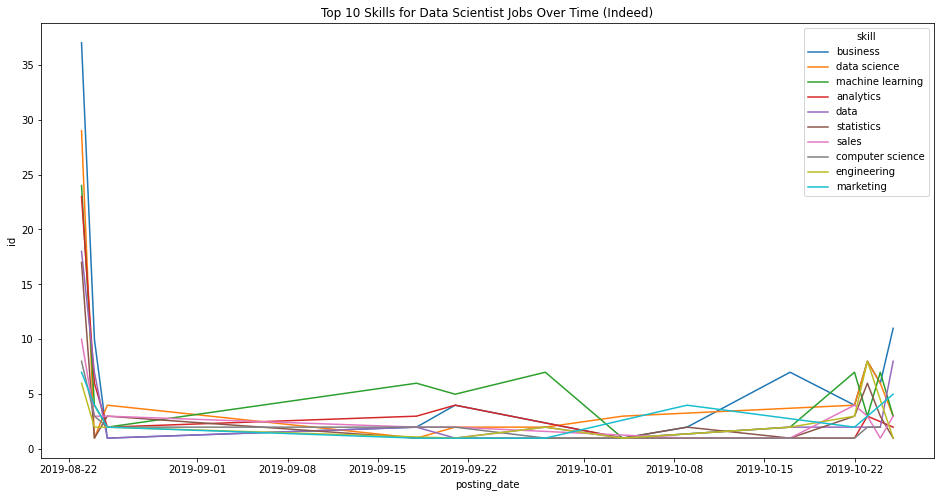

In [21]:
# using Seaborn instead of Altair
plt.figure(figsize=(16,8))
sns.lineplot(x='posting_date', y='id', data=line_chart_df[line_chart_df['skill'].isin(ds_top10)], hue='skill')
plt.title('Top 10 Skills for Data Scientist Jobs Over Time (Indeed)')

# Glassdoor EDA

In [22]:
glassdoor = pd.read_csv('glassdoor/datascientists.csv').drop(columns=['Unnamed: 0'])
glassdoor.sample(5)

posting_date                                        description  \
481  Oct 13, 2019  \r\nutilize big data and machine learning to b...   
304  Oct 22, 2019  analyse huge amounts of data within a data-dri...   
413  Oct 16, 2019  previous experience working as a data scientis...   
265  Oct 23, 2019  work with internal business stakeholders to un...   
44   Oct 31, 2019  analyze web scale data to discover patterns an...   

                                                 title         country  \
481                           Principal Data Scientist       Singapore   
304                      Junior Data Scientist (m/f/d)         Germany   
413                              Senior Data Scientist  United Kingdom   
265  Senior Data Scientist/ Machine Learning Resear...  United Kingdom   
44                                 Lead Data Scientist   United States   

                             employer  \
481  OVO (PT. Visionet Internasional)   
304                 TeamViewer Global   
413                          Citibank   
265                           Nielsen   
44                               Wish   

                                    industry            id     source  \
481                             unclassified  4.167362e+09  Glassdoor   
304             Computer Hardware & Software  4.144322e+09  Glassdoor   
413                                  Lending  4.126574e+09  Glassdoor   
265  Enterprise Software & Network Solutions  4.186156e+09  Glassdoor   
44         General Merchandise & Superstores  4.197689e+09  Glassdoor   

         lat       lng                   location  \
481   1.2931  103.8558                  Singapore   
304  52.5177   13.4055                     Berlin   
413  54.5833   -5.9333  Belfast, Northern Ireland   
265  51.7500   -1.2500            Oxford, England   
44   37.7750 -122.4183          San Francisco, CA   

                                       description_cln  
481  utilize big data machine learning build predic...  
304  analyse huge amounts data within data-driven c...  
413  previous experience working data scientist sta...  
265  work internal business stakeholders understand...  
44   analyze web scale data discover patterns provi...

In [23]:
glassdoor_skills = pd.read_csv('glassdoor/az_skills.csv').drop(columns=['Unnamed: 0'])
glassdoor_skills.sample(5)

id           skill category  confidence score
2932   4.157265e+09     communicate    Skill              0.99
11438  4.183774e+09    analyse data    Skill              0.74
2746   4.177471e+09      developing    Skill              0.70
10849  4.042458e+09  regularization    Skill              0.78
17666  4.134791e+09      developing    Skill              0.67

In [24]:
glassdoor_df = pd.merge(glassdoor_skills, glassdoor, on='id')
glassdoor_df.sample(5)

id                  skill category  confidence score  \
19903  4.053374e+09                     ml    Skill              0.98   
17346  4.095265e+09               products    Skill              0.99   
11699  4.025476e+09  business requirements    Skill              0.87   
31340  4.201839e+09            communicate    Skill              0.78   
16908  4.178159e+09                     ai    Skill              0.97   

       posting_date                                        description  \
19903  Oct 15, 2019  do you have in depth understanding of ml and a...   
17346  Oct 17, 2019  a/b test design and analysis.single & multi va...   
11699  Oct 23, 2019  good degree (2:1 or above) in a highly-quantit...   
31340   Nov 3, 2019  research and develop statistical learning mode...   
16908  Oct 17, 2019  extend and maintain our machine learning algor...   

                                                   title        country  \
19903      Senior Data Scientist - Global AI Accelerator         Sweden   
17346       Principal Data Scientist - LifeLock + Norton  United States   
11699  Manager - Data Scientist, Advisory, Performanc...      Singapore   
31340          Robotic Process Automation Data Scientist          India   
16908                              Junior Data Scientist        Germany   

                 employer                      industry     source      lat  \
19903  Ericsson-Worldwide   Telecommunications Services  Glassdoor  59.3333   
17346            Symantec  Computer Hardware & Software  Glassdoor  37.3861   
11699                  EY                    Accounting  Glassdoor   1.2931   
31340            Autodesk  Computer Hardware & Software  Glassdoor  12.9670   
16908              Adello       Advertising & Marketing  Glassdoor  49.0096   

            lng           location  \
19903   18.0500          Stockholm   
17346 -122.0828  Mountain View, CA   
11699  103.8558          Singapore   
31340   77.5873          Bengaluru   
16908    8.4049          Karlsruhe   

                                         description_cln  
19903  depth understanding ml ai technologies want ap...  
17346  ab test design analysissingle multi variate an...  
11699  good degree 21 highly-quantitative field eg ma...  
31340  research develop statistical learning models d...  
16908  extend maintain machine learning algorithms po...

In [25]:
alt.Chart(glassdoor_df[['id', 'skill', 'category', 'industry']].loc[(glassdoor_df['category'] == 'Skill') | (glassdoor_df['category'] == 'Product')]).mark_bar().encode(
    y=alt.Y('skill:N', sort=alt.SortField(field='count', order='descending'), title="Skill"),
    x=alt.X('count:Q', title="Number of Job Posts")
).properties(
    title='Top 20 Skills for Data Scientist Jobs (Glassdoor)'
).transform_aggregate(
    count='count()',
    groupby=['skill']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 20')

alt.Chart(...)

In [26]:
glassdoor_top10 = pd.DataFrame(line_chart_df.groupby('skill')['id'].count()).sort_values(by='id', ascending=False)[:10].reset_index()['skill'].to_list()

In [27]:
glassdoor_chart_df = glassdoor_df[['id', 'skill', 'category', 'industry', 'posting_date']].loc[(glassdoor_df['category'] == 'Skill') | (glassdoor_df['category'] == 'Product')]
glassdoor_chart_df = pd.DataFrame(glassdoor_chart_df.groupby(['posting_date', 'skill'])['id'].count()).reset_index().sort_values(by='id', ascending=False)
glassdoor_chart_df[glassdoor_chart_df['skill'].isin(glassdoor_top10)]

posting_date             skill  id
2930    Nov 6, 2019  machine learning  81
4342    Nov 8, 2019  machine learning  71
11270  Oct 29, 2019  machine learning  66
11936  Oct 30, 2019  machine learning  59
2623    Nov 6, 2019          business  58
...             ...               ...  ..
7379   Oct 19, 2019          business   1
7415   Oct 19, 2019        statistics   1
7397   Oct 19, 2019       engineering   1
7385   Oct 19, 2019  computer science   1
7437   Oct 20, 2019  computer science   1

[332 rows x 3 columns]

In [40]:
glassdoor_chart = alt.Chart(glassdoor_chart_df[glassdoor_chart_df['skill'].isin(glassdoor_top10)]).mark_circle(size=200).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=1000,
    height=500,
    title='Top 10 Skills for Data Scientist Jobs Over Time (Glassdoor)'
)

glassdoor_chart

alt.Chart(...)

# Indeed & Glassdoor Combined Data Visualizations

In [30]:
combined_df = pd.concat([ds_df[ds_df['country'] == 'United States'], glassdoor_df])
combined_df.sample(5)

id      skill    category confidence score  posting_date  \
1550   4197559416.0   modeling       Skill             0.98  Oct 31, 2019   
29322  3978107082.0     design       Skill             0.99  Jun 12, 2019   
1074   4124549884.0   database       Skill             0.95  Oct 31, 2019   
31847  4124950551.0    experts  PersonType             0.98   Nov 2, 2019   
10640  4187327700.0  economics       Skill              1.0  Oct 24, 2019   

                                             description  \
1550   constructing, validating/testing and deploying...   
29322  design, build, test and document data integrat...   
1074   research and develop statistical learning and ...   
31847  improve the quality of translation matches.cle...   
10640   masters in data science, economics, finance, ...   

                                        title                      employer  \
1550                   Network Data Scientist                         TELUS   
29322              Senior Data Scientist (FT)                    Hotelchamp   
1074       Senior Professional Data Scientist                           DXC   
31847                 Language Data Scientist                    Translated   
10640  Senior Data Scientist - Alexa Shopping  Amazon Dev Center (Tel Aviv)   

                      industry     source        country      lat      lng  \
1550    Staffing & Outsourcing  Glassdoor         Canada  43.6667 -79.4167   
29322              IT Services  Glassdoor    Netherlands  52.3500   4.9167   
1074               IT Services  Glassdoor  United States  29.9544 -90.0750   
31847  Advertising & Marketing  Glassdoor          Italy  41.9000  12.4833   
10640             unclassified  Glassdoor         Israel  32.0678  34.7647   

              location                                    description_cln  
1550           Toronto  constructing validatingtesting deploying artif...  
29322        Amsterdam  design build test document data integration bi...  
1074   New Orleans, LA  research develop statistical learning machine ...  
31847             Rome  improve quality translation matchesclean bitex...  
10640    Tel Aviv-Yafo  masters data science economics finance enginee...

In [32]:
alt.Chart(combined_df[['id', 'skill', 'category', 'industry']].loc[(combined_df['category'] == 'Skill') | (combined_df['category'] == 'Product')]).mark_bar().encode(
    y=alt.Y('skill:N', sort=alt.SortField(field='count', order='descending'), title="Skill"),
    x=alt.X('count:Q', title="Number of Job Posts")
).properties(
    title='Top 20 Skills from Glassdoor and Indeed'
).transform_aggregate(
    count='count()',
    groupby=['skill']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 20')

alt.Chart(...)

In [34]:
combined_chart_df = combined_df[['id', 'skill', 'category', 'industry', 'posting_date']].loc[((combined_df['category'] == 'Skill') | (combined_df['category'] == 'Product'))]
combined_top10 = pd.DataFrame(combined_chart_df.groupby('skill')['id'].count()).sort_values(by='id', ascending=False)[:10].reset_index()['skill'].to_list()

In [35]:
combined_chart_df = pd.DataFrame(combined_chart_df.groupby(['posting_date', 'skill'])['id'].count()).reset_index().sort_values(by='id', ascending=False)
combined_chart_df[combined_chart_df['skill'].isin(combined_top10)]

posting_date             skill  id
4455    Nov 6, 2019  machine learning  81
5867    Nov 8, 2019  machine learning  71
12795  Oct 29, 2019  machine learning  66
13461  Oct 30, 2019  machine learning  59
4148    Nov 6, 2019          business  58
...             ...               ...  ..
6546   Oct 11, 2019  machine learning   1
6519   Oct 10, 2019  computer science   1
6520   Oct 10, 2019              data   1
6199    Nov 9, 2019        algorithms   1
6208    Nov 9, 2019         analytics   1

[456 rows x 3 columns]

In [36]:
combined_chart_df[combined_chart_df['skill'].isin(combined_top10)]['posting_date'] = pd.to_datetime(combined_chart_df[combined_chart_df['skill'].isin(combined_top10)]['posting_date'])

In [37]:
combined_10 = combined_chart_df[combined_chart_df['skill'].isin(combined_top10)]
combined_10['posting_date'] = pd.to_datetime(combined_10['posting_date'])
combined_10

posting_date             skill  id
4455    2019-11-06  machine learning  81
5867    2019-11-08  machine learning  71
12795   2019-10-29  machine learning  66
13461   2019-10-30  machine learning  59
4148    2019-11-06          business  58
...            ...               ...  ..
6546    2019-10-11  machine learning   1
6519    2019-10-10  computer science   1
6520    2019-10-10              data   1
6199    2019-11-09        algorithms   1
6208    2019-11-09         analytics   1

[456 rows x 3 columns]

In [38]:
combined_chart = alt.Chart(combined_10).mark_circle(size=200).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=1000,
    height=500,
    title='Top 10 Skills from Combined Dataset Over Time'
)

combined_chart

alt.Chart(...)

# Plot skills individually

In [42]:
# create lists of top 20 and top 50 skills
combined_top20 = pd.DataFrame(combined_chart_df.groupby('skill')['id'].count()).sort_values(by='id', ascending=False)[:20].reset_index()['skill'].to_list()
combined_top50 = pd.DataFrame(combined_chart_df.groupby('skill')['id'].count()).sort_values(by='id', ascending=False)[:50].reset_index()['skill'].to_list()

In [43]:
# create dataframes for top 20 and top 50
combined_20 = combined_chart_df[combined_chart_df['skill'].isin(combined_top20)]
combined_20['posting_date'] = pd.to_datetime(combined_20['posting_date'])

combined_50 = combined_chart_df[combined_chart_df['skill'].isin(combined_top50)]
combined_50['posting_date'] = pd.to_datetime(combined_50['posting_date'])

In [50]:
combined_facet_10 = alt.Chart(combined_10).mark_circle(size=100).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=500,
    height=250
)

combined_facet_10.facet(
    facet=alt.Facet('skill:N', title=None),
    columns=2,
    title='Top 10 Skills from Combined Dataset Over Time'
)

alt.FacetChart(...)

In [45]:
combined_facet_20 = alt.Chart(combined_20).mark_circle(size=100).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=500,
    height=250
)

combined_facet_20.facet(
    facet=alt.Facet('skill:N', title=None),
    columns=2,
    title='Top 20 Skills from Combined Dataset Over Time'
)

alt.FacetChart(...)

In [47]:
combined_facet_50 = alt.Chart(combined_50).mark_circle(size=100).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=500,
    height=250
)

combined_facet_50.facet(
    facet=alt.Facet('skill:N', title=None),
    columns=2,
    title='Top 50 Skills from Combined Dataset Over Time'
)

alt.FacetChart(...)

In [60]:
combined_facet_10 = alt.Chart(combined_10[combined_10['skill'] == 'machine learning']).mark_circle(size=100).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    # color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=500,
    height=250,
    title='Machine Learning Skill from Combined Dataset Over Time'
)

combined_facet_10

alt.Chart(...)

In [61]:
combined_facet_10 = alt.Chart(combined_10[combined_10['skill'] == 'business']).mark_circle(size=100).encode(
    x=alt.X('posting_date:T', sort=alt.SortField(field='id', order='descending'), title='Posting Date (Jun - Nov 2019)'),
    y=alt.Y('id', title="Number of Job Posts"),
    # color=alt.Color('skill:N'),
    tooltip=['posting_date', 'id', 'skill']
).properties(
    width=500,
    height=250,
    title='Business Skill from Combined Dataset Over Time'
)

combined_facet_10

alt.Chart(...)